In [2]:
# !python -V

In [3]:
!pip install signatory==1.2.3.1.6.0 --no-cache-dir --force-reinstall

     |████████████████████████████████| 61 kB 11.0 MB/s eta 0:00:01
  Created wheel for signatory: filename=signatory-1.2.3.1.6.0-cp36-cp36m-linux_x86_64.whl size=5848359 sha256=46904276c441a54063c1f230040114c02883157318fa4839adbe6f24bc91e324
  Stored in directory: /tmp/pip-ephem-wheel-cache-505iwrs7/wheels/a1/ad/5d/4ba1358812ff3288b6e88573006340ab1567d7ed130d6f7d50
Successfully built signatory


In [4]:
!pip install git+https://github.com/patrick-kidger/torchcde.git

  Cloning https://github.com/patrick-kidger/torchcde.git to /tmp/pip-req-build-0zmrshsd
  Running command git clone -q https://github.com/patrick-kidger/torchcde.git /tmp/pip-req-build-0zmrshsd
  Created wheel for torchcde: filename=torchcde-0.1.0-py3-none-any.whl size=26753 sha256=f74ee0b6b2497acbd1957b144ffd02ee0ddd67e68134e7b5cf4f60253e76182e
  Stored in directory: /tmp/pip-ephem-wheel-cache-yew1_lgw/wheels/c5/39/cc/d565aba71de7160b7cf6d2162178e8ef8ab3c52c76405f65d9
Successfully built torchcde


In [5]:
import math
import torch
import torchcde

# Controlled differential equations (CDEs)

$$z_t = z_0 + \int_0^t f_\theta(z_s) dX_s$$

where $X$ is your data and $f_\theta$ is a neural network. 

In [23]:
class f_theta(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels):
        ######################
        # input_channels is the number of input channels in the data X. (Determined by the data.)
        # hidden_channels is the number of channels for z_t. (Determined by you.)
        ######################
        super(f_theta, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels

        self.linear1 = torch.nn.Linear(hidden_channels, 128)
        self.linear2 = torch.nn.Linear(128, input_channels * hidden_channels)

    ######################
    # The t argument is not used here; it can be used when you want your CDE to behave differently at different times
    ######################
    def forward(self, t, z):
        # z has shape (batch, hidden_channels)
        z = self.linear1(z)
        z = z.relu()
        z = self.linear2(z)
        z = z.tanh()
        ######################
        # Ignoring the batch dimension, the shape of the output tensor must be a matrix,
        # because we need it to represent a linear map from R^input_channels to R^hidden_channels.
        ######################
        z = z.view(z.size(0), self.hidden_channels, self.input_channels)
        return z

Next, we need to package $f_\theta$ up into a model that computes the integral.

In [73]:
class NeuralCDE(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, log_sig=False, interpolation_type='cubic_splines'):
        
        super(NeuralCDE, self).__init__()

        self.func = f_theta(input_channels, hidden_channels)
        self.initial = torch.nn.Linear(input_channels, hidden_channels)
        self.readout = torch.nn.Linear(hidden_channels, output_channels)
        
        self.log_sig = log_sig
        self.interpolation_type = interpolation_type
        
    def forward_linear_interpolation(self, X_input):
        coeffs = linear_interpolation_coeffs(X_input)
#         coeffs = linear_interpolation_coeffs(X_input, rectilinear=0)
        X = LinearInterpolation(coeffs)
    
        X0 = X.evaluate(X.interval[0])
        z0 = self.initial(X0)
        
        z_T = torchcde.cdeint(X=X,
                              z0=z0,
                              func=self.func,
                              t=X.interval,
                              method='dopri5',
                              options=dict(grid_points=X.grid_points, eps=1e-5))
        
        return z_T
    
        
    def forward_cubic_splines(self, X_input):
        coeffs = torchcde.natural_cubic_coeffs(X_input)
        X = torchcde.NaturalCubicSpline(coeffs)
        
        X0 = X.evaluate(X.interval[0])
        z0 = self.initial(X0)
        
        z_T = torchcde.cdeint(X=X,
                              z0=z0,
                              func=self.func,
                              t=X.interval)
        
        return z_T
        
        
    def forward_logsig(self, X_input, depth=2, window=5):
        x, t = torchcde.logsignature_windows(X_input, depth, window)
        return x
    
        
    def forward(self, X_input):
        
        if log_sig:
            X_input = self.forward_logsig(X_input)
            z_T = self.forward_linear_interpolation(X_input)
        
        else:
            if self.interpolation_type=='cubic_splines':
                z_T = self.forward_cubic_splines(X_input)

            else:
                z_T = self.forward_linear_interpolation(X_input)
            
        z_T = z_T[:, 1]
        pred_y = self.readout(z_T)
        return pred_y

In [35]:
def get_data():
    ######################
    # Simple example which generates some spirals, some going clockwise, some going anticlockwise.
    ######################
    t = torch.linspace(0., 4 * math.pi, 100)

    start = torch.rand(128) * 2 * math.pi
    x_pos = torch.cos(start.unsqueeze(1) + t.unsqueeze(0)) / (1 + 0.5 * t)
    x_pos[:64] *= -1
    y_pos = torch.sin(start.unsqueeze(1) + t.unsqueeze(0)) / (1 + 0.5 * t)
    x_pos += 0.01 * torch.randn_like(x_pos)
    y_pos += 0.01 * torch.randn_like(y_pos)
    ######################
    # Easy to forget gotcha: time should be included as a channel; Neural CDEs need to be explicitly told the
    # rate at which time passes. Here, we have a regularly sampled dataset, so appending time is pretty simple.
    ######################
    X = torch.stack([t.unsqueeze(0).repeat(128, 1), x_pos, y_pos], dim=2)
    y = torch.zeros(128)
    y[:64] = 1

    perm = torch.randperm(128)
    X = X[perm]
    y = y[perm]

    ######################
    # X is a tensor of observations, of shape (batch=128, sequence=100, channels=3)
    # y is a tensor of labels, of shape (batch=128,), either 0 or 1 corresponding to anticlockwise or clockwise respectively.
    ######################
    return X, y

In [36]:
train_X, train_y = get_data()

In [37]:
import matplotlib.pyplot as plt

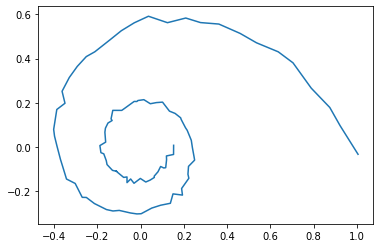

In [38]:
x = train_X.numpy()[2]
plt.plot(x[:,1], x[:,2])
plt.show()

In [39]:
# input_channels=3 because we have both the horizontal and vertical position of a point in the spiral, and time.
# hidden_channels=8 is the number of hidden channels for the evolving z_t, which we get to choose.
# output_channels=1 because we're doing binary classification.

model = NeuralCDE(input_channels=3, hidden_channels=8, output_channels=1)
optimizer = torch.optim.Adam(model.parameters())

In [40]:
train_dataset = torch.utils.data.TensorDataset(train_X, train_y)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32)

In [41]:
num_epochs = 30

for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch_coeffs, batch_y = batch
        pred_y = model(batch_coeffs).squeeze(-1)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(pred_y, batch_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('Epoch: {}   Training loss: {}'.format(epoch, loss.item()))

Epoch: 0   Training loss: 0.6884132623672485
Epoch: 1   Training loss: 0.5923997163772583
Epoch: 2   Training loss: 0.5667720437049866
Epoch: 3   Training loss: 0.5516722202301025
Epoch: 4   Training loss: 0.5251402854919434
Epoch: 5   Training loss: 0.4281567633152008
Epoch: 6   Training loss: 0.33712008595466614
Epoch: 7   Training loss: 0.24268469214439392
Epoch: 8   Training loss: 0.12373997271060944
Epoch: 9   Training loss: 0.03256629407405853
Epoch: 10   Training loss: 0.006167020183056593
Epoch: 11   Training loss: 0.0010502887889742851
Epoch: 12   Training loss: 0.00034435439738444984
Epoch: 13   Training loss: 0.0001677817926974967
Epoch: 14   Training loss: 0.000108391119283624
Epoch: 15   Training loss: 8.030966273508966e-05
Epoch: 16   Training loss: 6.62156890030019e-05
Epoch: 17   Training loss: 5.862833859282546e-05
Epoch: 18   Training loss: 5.332798173185438e-05
Epoch: 19   Training loss: 5.024005804443732e-05
Epoch: 20   Training loss: 4.823607741855085e-05
Epoch: 21

In [43]:
test_X, test_y = get_data()
pred_y = model(test_X).squeeze(-1)
binary_prediction = (torch.sigmoid(pred_y) > 0.5).to(test_y.dtype)
prediction_matches = (binary_prediction == test_y).to(test_y.dtype)
proportion_correct = prediction_matches.sum() / test_y.size(0)
print('Test Accuracy: {}'.format(proportion_correct))

Test Accuracy: 1.0


In [69]:
batch, length, channels = 1, 100, 2
x = torch.rand(batch, length, channels)
depth, window = 3, 1

In [70]:
x.shape

torch.Size([1, 100, 2])

In [71]:
x, t = torchcde.logsignature_windows(x, depth, window)

In [72]:
x.shape

torch.Size([1, 100, 5])